In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load data set, check dimensions and perform time lag.

###The timelag value is based on the paper.

In [ ]:
file_path = "/content/drive/My Drive/DeepLearning/Project6/dimredux-challenge-01-data.npz"

In [66]:
data  = np.load(file_path)
items = data.files
print(items)

['data_x', 'validation_x', 'validation_y']


In [ ]:
data_x          = data[items[0]]
validation_x    = data[items[1]]
validation_y    = data[items[2]]
original_data_x = np.copy(data_x)
timelag         = 8
data_x          = original_data_x[:-timelag]
shifted_data_x  = original_data_x[timelag:]

In [68]:

print("Length: %d" % len(data_x))
print("Shape: ", data_x.shape)

print("Length: %d" % len(validation_x))
print("Shape: ", validation_x.shape)

print("Length: %d" %  len(validation_y))
print("Shape: ",validation_y.shape)

Length: 99992
Shape:  (99992, 3)
Length: 1000
Shape:  (1000, 3)
Length: 1000
Shape:  (1000,)


#Preliminary visualisation of validation set using a 3 dimensional plot and a TSNE embedding.

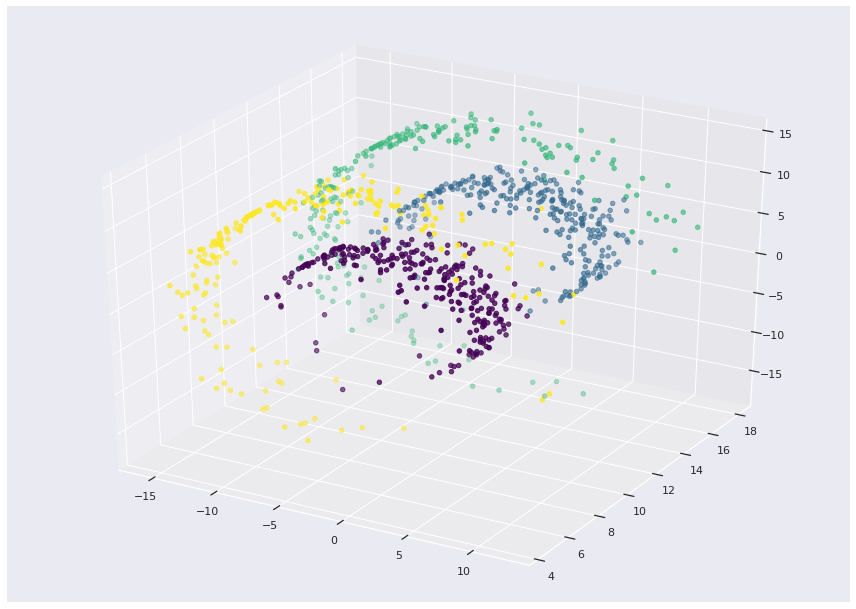

In [69]:
fig = plt.figure()
ax = Axes3D(fig)
infernofunc=plt.get_cmap("viridis")
ax.scatter(validation_x[:, 0], validation_x[:, 1], validation_x[:, 2], c=validation_y, cmap=infernofunc)
plt.show()

In [ ]:
tsne = TSNE()
X_embedded = tsne.fit_transform(validation_x)

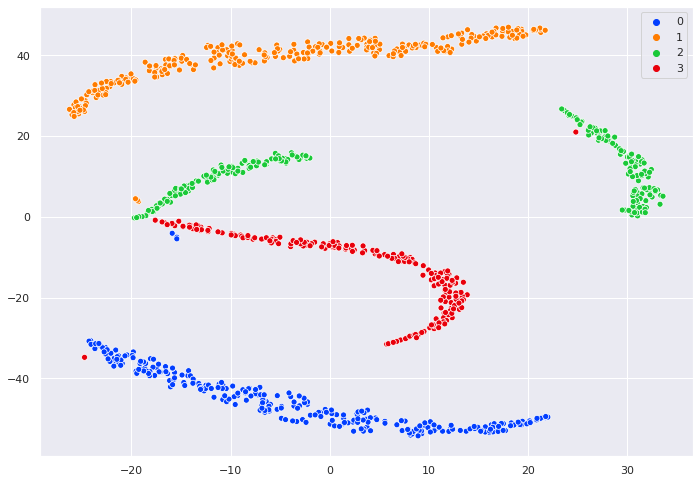

In [71]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 4)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=validation_y, legend='full', palette=palette)

# Preprocessing of the data, performing centering and pca whitening, data is converted to tensors

In [ ]:
data_x = data_x - np.mean(data_x, axis=0)
shifted_data_x =  shifted_data_x - np.mean(shifted_data_x, axis=0)
original_data_x = original_data_x -  np.mean(original_data_x, axis=0)
validation_x = validation_x - np.mean(validation_x, axis=0)

In [ ]:
pca_whiten = PCA(whiten=True)

data_x = pca_whiten.fit_transform(data_x)
shifted_data_x = pca_whiten.fit_transform(shifted_data_x)
original_data_x = pca_whiten.fit_transform(original_data_x)
validation_x = pca_whiten.fit_transform(validation_x)

In [ ]:
original_data_x = torch.tensor(original_data_x, dtype=torch.float)
data_x = torch.tensor(data_x, dtype=torch.float)
shifted_data_x = torch.tensor(shifted_data_x, dtype=torch.float)

In [113]:

print("Shape: ", original_data_x.size())

print("Shape: ", data_x.size())

print("Shape: ",shifted_data_x.size())

Shape:  torch.Size([100000, 3])
Shape:  torch.Size([99992, 3])
Shape:  torch.Size([99992, 3])


#Define Timelagged Autoencoder
###Using an encoder consisting of 3 recurrent neural networks and a decoder consisting of 2 RNNs and a dense linear NN
###In between each layer we use a dropout of 0.2 to prevent overfitting.
###As the activation function for all layers we use LeakyReLU with a negative slope of alpha=0.3 .

###Based on https://github.com/tugot17/RNN-Time-lagged-Autoencoder/blob/master/RNN_Time_lagged_autoencoder.ipynb , with some deviations


In [ ]:
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Hidden Layers
        self.encoderRNN1 = nn.RNN(3, 200)
        self.encoderRNN2 = nn.RNN(200, 100)
        self.encoderRNN_Extraction = nn.RNN(100, 1)
        self.decoderRNN1 = nn.RNN(3, 100)
        self.decoderRNN2 = nn.RNN(100, 200)

        #OutPut Layer
        self.out = nn.Linear(200, 3)

        #DropOut Layers
        self.dropLayer1 = nn.Dropout(p=0.2)
        self.dropLayer2 = nn.Dropout(p=0.2)
        self.dropLayer3 = nn.Dropout(p=0.2)
        self.dropLayer4 = nn.Dropout(p=0.2)

        # Define activation function and softmax output 
        self.leakyReLU = nn.LeakyReLU(negative_slope=0.3)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        # ENCODER
        x = self.encoderRNN1(x)
        x = self.leakyReLU(x[0])
        x = self.dropLayer1(x)
        x = self.encoderRNN2(x)
        x = self.leakyReLU(x[0])
        x = self.dropLayer2(x)
        x = self.encoderRNN_Extraction(x)
        extraction = self.leakyReLU(x[0])
        decoder_input = extraction[:,:].repeat(1,1, 3)
        # DECODER 
        x = self.decoderRNN1(decoder_input)
        x = self.leakyReLU(x[0])
        x = self.dropLayer3(x)
        x = self.decoderRNN2(x)
        x = self.leakyReLU(x[0])
        x = self.dropLayer4(x)
        x = self.out(x[0])

        return (x,extraction,decoder_input)

In [ ]:
model = Network()

In [18]:
model

Network(
  (encoderRNN1): RNN(3, 200)
  (encoderRNN2): RNN(200, 100)
  (encoderRNN_Extraction): RNN(100, 1)
  (decoderRNN1): RNN(3, 100)
  (decoderRNN2): RNN(100, 200)
  (out): Linear(in_features=200, out_features=3, bias=True)
  (dropLayer1): Dropout(p=0.2, inplace=False)
  (dropLayer2): Dropout(p=0.2, inplace=False)
  (dropLayer3): Dropout(p=0.2, inplace=False)
  (dropLayer4): Dropout(p=0.2, inplace=False)
  (leakyReLU): LeakyReLU(negative_slope=0.3)
)

In [ ]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 100
EPOCHS = 120

In [ ]:
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TimeShiftDataset(Dataset):

    def __init__(self, x_data, x_data_shifted):

        self.x_data         = x_data
        self.x_data_shifted = x_data_shifted

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        sample = (self.x_data[idx],self.x_data_shifted[idx])
        return sample

In [ ]:
dataset = TimeShiftDataset(data_x, shifted_data_x)

In [ ]:
trainloader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
for data_x,shifted_data_x in trainloader:
  test = data_x

#Run Neural Network

In [31]:
for e in range(EPOCHS):
    running_loss = 0
    for data in trainloader:

        # Training pass
        optimizer.zero_grad()
        data_x = data[0].unsqueeze(0)
        output,extraction,decoder_input = model(data_x)

        shifted_data_x = data[1].unsqueeze(0)
        loss = criterion(output, shifted_data_x)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch: ", e)
        print(f"Training loss: {running_loss/len(trainloader)}")

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1, 100, 3])) that is different to the input size (torch.Size([100, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1, 92, 3])) that is different to the input size (torch.Size([92, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training loss: 0.9704805340766907
Training loss: 0.9491427773237229
Training loss: 0.9404991033673287
Training loss: 0.9326099282801151
Training loss: 0.9277016350030899
Training loss: 0.9253433418869972
Training loss: 0.9234976990222931
Training loss: 0.9215042190253735
Training loss: 0.9160611020028591
Training loss: 0.9116504538059235
Training loss: 0.9081756533682346
Training loss: 0.9060513973534107
Training loss: 0.9044461611807346
Training loss: 0.9024145746827126
Training loss: 0.9007937394678592
Training loss: 0.8999459649324417
Training loss: 0.900276176571846
Training loss: 0.8989245870411396
Training loss: 0.8990541283786296
Training loss: 0.897499254822731
Training loss: 0.8981549155712127
Training loss: 0.8972339226007462
Training loss: 0.8969117221832276
Training loss: 0.8970838616490364
Training loss: 0.8962400893867016
Training loss: 0.8964709865152836
Training loss: 0.8959802331626415
Training loss: 0.89636805960536
Training loss: 0.8954940231144428
Training loss: 0.8

#Output of 3D data to 1D data transformation and Visualization

In [108]:
model.eval()

Network(
  (encoderRNN1): RNN(3, 200)
  (encoderRNN2): RNN(200, 100)
  (encoderRNN_Extraction): RNN(100, 1)
  (decoderRNN1): RNN(3, 100)
  (decoderRNN2): RNN(100, 200)
  (out): Linear(in_features=200, out_features=3, bias=True)
  (dropLayer1): Dropout(p=0.2, inplace=False)
  (dropLayer2): Dropout(p=0.2, inplace=False)
  (dropLayer3): Dropout(p=0.2, inplace=False)
  (dropLayer4): Dropout(p=0.2, inplace=False)
  (leakyReLU): LeakyReLU(negative_slope=0.3)
)

In [ ]:
unsqueezed_data_x   = original_data_x.unsqueeze(0) 
output,extraction,output_value = model(unsqueezed_data_x)

In [115]:
output.shape

torch.Size([100000, 3])

In [116]:
vec = extraction.detach().numpy()
vec.shape

(1, 100000, 1)

In [ ]:
flat = vec.flatten()

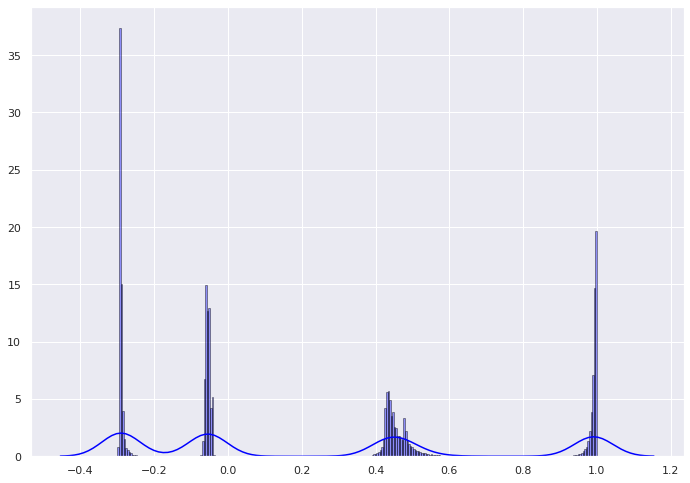

In [119]:
# seaborn histogram
sns.distplot(flat, hist=True, kde=True, color = 'blue',bins=300,
             hist_kws={'edgecolor':'black'})

#Use Gaussian Mixture Models with EM algorithm to classify the states

In [ ]:
from sklearn import mixture

In [ ]:
bb = np.squeeze(vec,axis=0)
timeseries = np.arange(1,100001,1)

In [122]:
clf = mixture.GaussianMixture(n_components=4)
clf.fit(bb)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
target = clf.predict(bb)

In [124]:
bb_flat = bb.flatten()
print(vec.shape)

(1, 100000, 1)


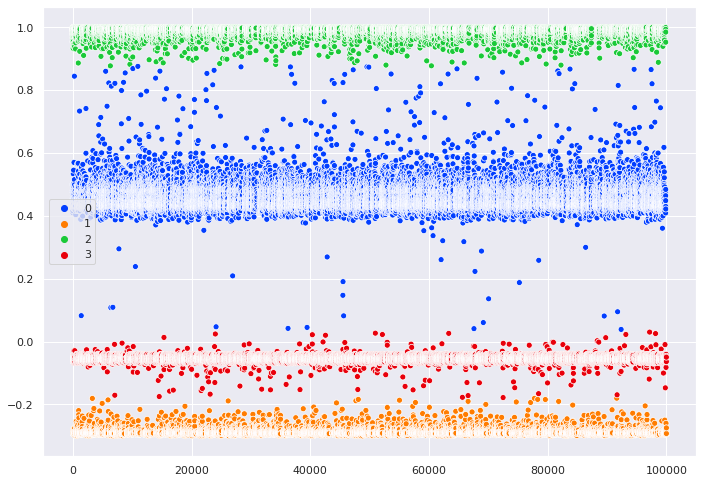

In [128]:
sns.scatterplot(timeseries,bb_flat,hue=target,palette=palette)

#Determine Accuracy with Validation Set

In [ ]:
validation_x = torch.tensor(validation_x, dtype=torch.float)

In [ ]:
validation_x = validation_x.unsqueeze(0)

In [ ]:
output,extraction,output_value = model(validation_x)

In [ ]:
val = extraction.detach().numpy()

In [ ]:
val = np.squeeze(val,axis=0)

In [134]:
clf = mixture.GaussianMixture(n_components=4)
clf.fit(val)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
predict = clf.predict(val)

In [185]:
print(predict)

[1 1 1 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 0 0 0 0 0 0 3 3 3 3 0 0 0 0 0 0 2 2 0
 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 2 0 2 0 0 0 0 2 0 0 0 0 0 0
 0 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 2 0 0 1 1 2 1 1 1 0 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 2 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 0 0 0 2 0 0 2 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 0 2 0 0 0 0 0 0 0 2 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 0 3 2 3 3
 3 3 3 3 3 3 2 3 2 3 3 3 

In [178]:
print(validation_y)

[2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [186]:
predict_2=np.copy(predict)
predict_2[np.where(predict==0)]=1
predict_2[np.where(predict==1)]=2
predict_2[np.where(predict==2)]=3
predict_2[np.where(predict==3)]=0
print(predict_2)

[2 2 2 2 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 3 3 1
 3 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 3 1 3 1 3 1 1 1 1 3 1 1 1 1 1 1
 1 3 2 2 2 2 2 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 3 1 1 1 1
 1 1 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 3 1 1 2 2 3 2 2 2 1 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 1 1
 1 1 1 3 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 3 1 1 3 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 3 1 1 1 1 1 1 1 3 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 3 2 3 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 1 0 3 0 0
 0 0 0 0 0 0 3 0 3 0 0 0 

In [ ]:
acc_val = (1 - np.count_nonzero(predict_2-validation_y) / len(predict_2-validation_y))

In [190]:
print(acc_val)

0.9339999999999999
